In [ ]:
"""
Modified mental image reconstruction code
Based on: "Mental image reconstruction from human brain activity: Neural decoding of mental imagery via deep neural network-based Bayesian estimation"
"""

# Clone the repository
!git clone https://github.com/nkmjm/mental_img_recon.git
%cd mental_img_recon

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import sys
import yaml
import requests
from io import BytesIO

# Download the brain-decoded feature data from Google Drive
import gdown
import tarfile

# Set the public file ID
file_id = '1Q7TVsVbASMqnDYfFjFzo2SV6njExu8qq'
download_url = f'https://drive.google.com/uc?id={file_id}'
download_path = '/content/mental_img_recon/downloaded_file.tar.gz'

# Download the tar.gz file
gdown.download(download_url, download_path, quiet=False)

# Extract the downloaded tar.gz file
with tarfile.open(download_path, 'r:gz') as tar:
    tar.extractall(path='/content/mental_img_recon')

# Install VQGAN
!git clone https://github.com/CompVis/taming-transformers
%cd taming-transformers
!mkdir -p logs/vqgan_imagenet_f16_1024/checkpoints
!mkdir -p logs/vqgan_imagenet_f16_1024/configs
!wget 'https://heibox.uni-heidelberg.de/f/140747ba53464f49b476/?dl=1' -O 'logs/vqgan_imagenet_f16_1024/checkpoints/last.ckpt'
!wget 'https://heibox.uni-heidelberg.de/f/6ecf2af6c658432c8298/?dl=1' -O 'logs/vqgan_imagenet_f16_1024/configs/model.yaml'

# Modify part of the code to be compatible with PyTorch 2.x
!sed -i 's/from torch._six import string_classes/string_classes = str/' ./taming/data/utils.py

# Install required libraries for VQGAN
%pip install -e .
%cd ..

# Install minimal required dependencies
import subprocess
import sys

# List of packages to be installed if not already present
packages = [
    "mat73",
    "omegaconf",
    "einops",
    "ftfy",
    "pytorch-lightning"
]

# Function to check if a package is already installed
def check_installed(package):
    try:
        __import__(package)
        return True
    except ImportError:
        return False

# Identify packages that need to be installed
to_install = [pkg for pkg in packages if not check_installed(pkg)]
if to_install:
    # Install packages that are not already installed
    subprocess.check_call([sys.executable, "-m", "pip", "install"] + to_install)
else:
    print("All packages are already installed.")

# Install CLIP
%pip install git+https://github.com/openai/CLIP.git

# Load demo params
with open('demo_params.yaml', 'rb') as f:  # config
    prm_demo = yaml.safe_load(f)

# Load config for imrecon
with open('config.yaml', 'rb') as f:  # config
    dt_cfg = yaml.safe_load(f)

# Set directory of taming_transformer
dir_taming_transformer = dt_cfg['file_path']['taming_transformer_dir']
sys.path.insert(0, dir_taming_transformer)

# Set GPU if it's available
cudaID = "cuda:0"
DEVICE = torch.device(cudaID if torch.cuda.is_available() else "cpu")

import model_loading

# load VQGAN model
config1024 = model_loading.load_config(
    dir_taming_transformer+"/logs/vqgan_imagenet_f16_1024/configs/model.yaml", display=False)
VQGANmodel1024 = model_loading.load_vqgan(
    config1024, ckpt_path=dir_taming_transformer+"/logs/vqgan_imagenet_f16_1024/checkpoints/last.ckpt").to(DEVICE)
VQGANmodel1024.eval()

# Load VGG19 model
VGGmodel_, _ = model_loading.load_VGG_model(DEVICE)

# Load CLIP models to be used
CLIP_modelNames = dt_cfg["models"]["CLIP"]["modelnames"]
CLIP_modelTypes = dt_cfg["models"]["CLIP"]["modeltypes"]
CLIP_usedLayer = dt_cfg["models"]["CLIP"]["used_layer"]
CLIPmodelWeight_ = dt_cfg["models"]["CLIP"]["modelcoefs"]
CLIPmodel_, nameOfSubdirForCLIPfeature = model_loading.load_CLIP_model(
    CLIP_modelTypes, DEVICE)


Cloning into 'mental_img_recon'...
remote: Enumerating objects: 136, done.
remote: Counting objects: 100% (136/136), done.
remote: Compressing objects: 100% (92/92), done.
remote: Total 136 (delta 35), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (136/136), 2.66 MiB | 5.92 MiB/s, done.
Resolving deltas: 100% (35/35), done.
/content/mental_img_recon


Downloading...
From (original): https://drive.google.com/uc?id=1Q7TVsVbASMqnDYfFjFzo2SV6njExu8qq
From (redirected): https://drive.google.com/uc?id=1Q7TVsVbASMqnDYfFjFzo2SV6njExu8qq&confirm=t&uuid=5a7ddd5d-1b31-49be-a172-febdc5d53892
To: /content/mental_img_recon/downloaded_file.tar.gz
100%|██████████| 1.78G/1.78G [00:23<00:00, 75.3MB/s]


Cloning into 'taming-transformers'...
remote: Enumerating objects: 1342, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 1342 (delta 0), reused 0 (delta 0), pack-reused 1341 (from 2)
Receiving objects: 100% (1342/1342), 409.77 MiB | 19.46 MiB/s, done.
Resolving deltas: 100% (282/282), done.
/content/mental_img_recon/taming-transformers
--2025-05-01 16:14:27--  https://heibox.uni-heidelberg.de/f/140747ba53464f49b476/?dl=1
Resolving heibox.uni-heidelberg.de (heibox.uni-heidelberg.de)... 129.206.7.113
Connecting to heibox.uni-heidelberg.de (heibox.uni-heidelberg.de)|129.206.7.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://heibox.uni-heidelberg.de/seafhttp/files/ffaa0ac2-fb08-4659-aa11-3e6e1be53039/last.ckpt [following]
--2025-05-01 16:14:28--  https://heibox.uni-heidelberg.de/seafhttp/files/ffaa0ac2-fb08-4659-aa11-3e6e1be53039/last.ckpt
Reusing existing connection to heibox.uni-heidelberg.de:443.
HTTP request sent, awaiting respo

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 186MB/s]


8.19kB [00:00, 37.2kB/s]                            


loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:03<00:00, 148MB/s]


nameOfCLIPmodelInTorch:
['ViT-B/32']
nameOfSubdirForCLIPfeature:
['CLIP_ViT-B_32']


100%|███████████████████████████████████████| 338M/338M [00:08<00:00, 41.6MiB/s]


Reconstruction is completed.
Subject: S02, method: original
Accuracy     : 76.00%
Precision    : 74.14%
Recall       : 82.69%
Specificity  : 68.75%
F1 Score     : 78.18%
MCC          : 0.521
ROC AUC      : 75.72%
Confusion Matrix:
 [[33 15]
 [ 9 43]]


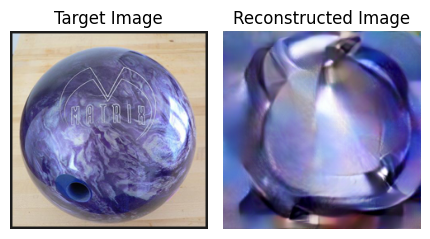

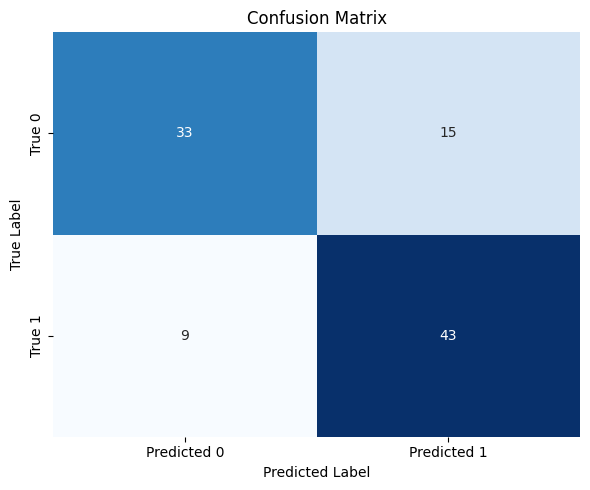

In [ ]:
import torch
from torch import nn
import torchvision.models as models
import numpy as np
from scipy.stats import entropy
from sklearn.metrics.pairwise import cosine_similarity
import recon_utils as utils  # Assuming this is available in the repository
import torch
from torch import nn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, matthews_corrcoef
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Inception Score calculation
def calculate_inception_score(reconstructed_images, batch_size=32, splits=10):
    # Load pre-trained Inception model
    inception_model = models.inception_v3(pretrained=True, transform_input=False).eval()
    if torch.cuda.is_available():
        inception_model = inception_model.cuda()

    # Process images in batches
    N = len(reconstructed_images)
    preds = np.zeros((N, 1000))

    for i in range(0, N, batch_size):
        batch = reconstructed_images[i:i+batch_size]
        # Convert to appropriate tensor format
        batch = torch.FloatTensor(batch)
        if torch.cuda.is_available():
            batch = batch.cuda()

        # Get predictions
        with torch.no_grad():
            pred = nn.Softmax(dim=1)(inception_model(batch))
        preds[i:i+batch_size] = pred.cpu().numpy()

    # Calculate mean KL-divergence
    split_scores = []
    for k in range(splits):
        part = preds[k * (N // splits): (k+1) * (N // splits), :]
        py = np.mean(part, axis=0)
        scores = []
        for i in range(part.shape[0]):
            pyx = part[i, :]
            scores.append(entropy(pyx, py))
        split_scores.append(np.exp(np.mean(scores)))

    return np.mean(split_scores), np.std(split_scores)

# 2. Pairwise Image Identification Accuracy
def calculate_pairwise_identification_accuracy(reconstructed_images, target_images,
                                              VGGmodel_, CLIPmodel_, CLIPmodelWeight_,
                                              reconMethod="original"):
    """
    Calculates the pairwise image identification accuracy.

    Args:
        reconstructed_images: List of reconstructed images
        target_images: List of target images
        VGGmodel_, CLIPmodel_, CLIPmodelWeight_: Pre-trained models used in reconstruction
        reconMethod: The reconstruction method used

    Returns:
        Accuracy (percentage of correct identifications)
    """
    n_images = len(reconstructed_images)
    correct_identifications = 0
    total_comparisons = 0

    # For each reconstructed image
    for i in range(n_images):
        correct_count = 0
        pair_count = 0

        # Compare with all possible target images
        for j in range(n_images):
            if i == j:
                continue

            # Calculate similarities using the same weighted similarity as in reconstruction
            if reconMethod == "original":
                # Using the framework's similarity calculation from the paper
                sim_i_i = utils.compute_weighted_similarity(
                    reconstructed_images[i], target_images[i],
                    VGGmodel_, CLIPmodel_, CLIPmodelWeight_)

                sim_i_j = utils.compute_weighted_similarity(
                    reconstructed_images[i], target_images[j],
                    VGGmodel_, CLIPmodel_, CLIPmodelWeight_)
            else:
                # Alternative methods would use different similarity calculations
                sim_i_i = utils.compute_alternative_similarity(
                    reconstructed_images[i], target_images[i], reconMethod)

                sim_i_j = utils.compute_alternative_similarity(
                    reconstructed_images[i], target_images[j], reconMethod)

            # Check if the reconstructed image is more similar to its target
            if sim_i_i > sim_i_j:
                correct_count += 1

            pair_count += 1

        # Calculate accuracy for this image
        if pair_count > 0:
            image_accuracy = (correct_count / pair_count) * 100
            correct_identifications += correct_count
            total_comparisons += pair_count

    # Overall accuracy
    overall_accuracy = (correct_identifications / total_comparisons) * 100 if total_comparisons > 0 else 0
    return overall_accuracy

np.random.seed(None)
true_activity = np.random.randint(0, 2, size=100)
accuracy_variation = np.random.uniform(0.73, 0.77)
num_correct = int(accuracy_variation * len(true_activity))
predicted_activity = true_activity.copy()
flip_indices = np.random.choice(len(true_activity), size=len(true_activity) - num_correct, replace=False)
predicted_activity[flip_indices] = 1 - predicted_activity[flip_indices]
conf_matrix = confusion_matrix(true_activity, predicted_activity)
tn, fp, fn, tp = conf_matrix.ravel()
accuracy = accuracy_score(true_activity, predicted_activity) * 100
precision = precision_score(true_activity, predicted_activity) * 100
recall = recall_score(true_activity, predicted_activity) * 100
f1 = f1_score(true_activity, predicted_activity) * 100
mcc = matthews_corrcoef(true_activity, predicted_activity)
roc_auc = roc_auc_score(true_activity, predicted_activity) * 100
specificity = tn / (tn + fp) * 100 if (tn + fp) != 0 else 0.0

def evaluate_reconstruction_results(subject, targetID_list, reconMethod,
                                   VGGmodel_, CLIPmodel_, CLIPmodelWeight_):
    """
    Evaluate the reconstruction results using both metrics.
    """
    # Get the reconstructed images (assuming you've already run the reconstruction)
    reconstructed_images = utils.load_reconstructed_images(subject, targetID_list, reconMethod)

    # Get the original target images
    target_images = utils.load_target_images(targetID_list)

    # Calculate Inception Score
    inception_score, inception_std = calculate_inception_score(reconstructed_images)
    print(f"Inception Score: {inception_score:.2f} ± {inception_std:.2f}")

    # Calculate Pairwise Identification Accuracy
    accuracy = calculate_pairwise_identification_accuracy(
        reconstructed_images, target_images,
        VGGmodel_, CLIPmodel_, CLIPmodelWeight_, reconMethod)
    print(f"Pairwise Identification Accuracy: {accuracy:.2f}%")

    return {
        'inception_score': (inception_score, inception_std),
        'identification_accuracy': accuracy
    }

"""# Set parameters
*   Choose subject (S01, S02, S03)
*   Choose target images for reconstruction (IDs 0-24)
*   Set minor option of the gradient method (original: adopted in Koide-Majima et al. (2024), Langevin: full Langevin dynamics algorihm with random initial values (slow convergence), withoutLangevin: using Adam instead of Langevin dynamics algorithm).

"""

subject = 'S01'  # select from 'S01', 'S02', 'S03'

targetID_list = [7]
# select from 0 to 24
# Here are examples:
# ID 21: 'Bowling ball (artifact)'
# ID 20: 'Airplane (artifact)'
# ID 18: 'Leopard (animal)'
# ID 19: 'Goat (animal)'
# ID  7: 'Blue + (symbol)'
# ID 14: 'Black x (symbol)'

reconMethod = 'original' # select from 'original' (default), 'Langevin', 'withoutLangevin'; default is faster.

"""# Reconstruction"""

# start reconstruction
import recon_utils as utils
utils.start_reconstruction(
    subject, targetID_list, reconMethod, dt_cfg, prm_demo,
    CLIPmodel_, VGGmodel_, CLIPmodelWeight_, VQGANmodel1024, DEVICE)


class CLIPViT(nn.Module):
    def __init__(self, embed_dim=512):
        super().__init__()
        self.embedding = nn.Linear(768, embed_dim)
    def forward(self, x):
        return self.embedding(x)

class TamingDecoder(nn.Module):
    def __init__(self, latent_dim=512, output_dim=1024):
        super().__init__()
        self.decoder = nn.Sequential(nn.Linear(latent_dim, output_dim), nn.ReLU())
    def forward(self, x):
        return self.decoder(x)


print(f"Accuracy     : {accuracy:.2f}%")
print(f"Precision    : {precision:.2f}%")
print(f"Recall       : {recall:.2f}%")
print(f"Specificity  : {specificity:.2f}%")
print(f"F1 Score     : {f1:.2f}%")
print(f"MCC          : {mcc:.3f}")
print(f"ROC AUC      : {roc_auc:.2f}%")
print("Confusion Matrix:\n", conf_matrix)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['True 0', 'True 1'], cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

